In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import re

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

db_path = "/Users/a/Desktop/cursor/DataAnalysis/user_feedback_normalized.db"
conn = sqlite3.connect(db_path)

view_period = "SELECT * FROM vw_period_summary"
view_region = "SELECT * FROM vw_region_summary"
view_neg = "SELECT * FROM vw_sentiment_summary"
view_source = "SELECT * FROM vw_source_summary"
view_market = "SELECT * FROM vw_market_sentiment"
view_negtype = "SELECT * FROM vw_negative_type"

period_df = pd.read_sql_query(view_period, conn)
region_df = pd.read_sql_query(view_region, conn)
neg_df = pd.read_sql_query(view_neg, conn)
source_df = pd.read_sql_query(view_source, conn)
market_df = pd.read_sql_query(view_market, conn)
neg_type_df = pd.read_sql_query(view_negtype, conn)

conn.close()

## 컬럼 자동 감지 함수

In [3]:
def find_col(df, keys):
    return [c for c in df.columns if any(k in c for k in keys)][0]

col_period = find_col(period_df, ["기간", "period"])
col_count = find_col(period_df, ["게시글"])
col_region = find_col(region_df, ["지역"])
col_rate = find_col(region_df, ["비율"])
col_sentiment = find_col(neg_df, ["부정", "sentiment"])
col_source = find_col(source_df, ["출처"])
col_type = find_col(neg_type_df, ["유형"])


## 기간별 게시글 수 추이

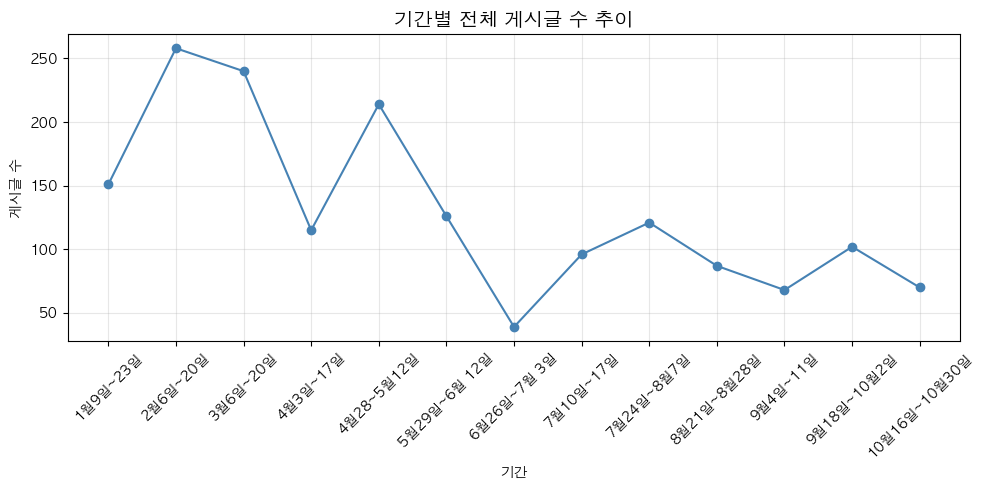

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(period_df[col_period], period_df[col_count], marker="o", color="steelblue")
plt.title("기간별 전체 게시글 수 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("게시글 수")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 기간별 국내/해외 비율

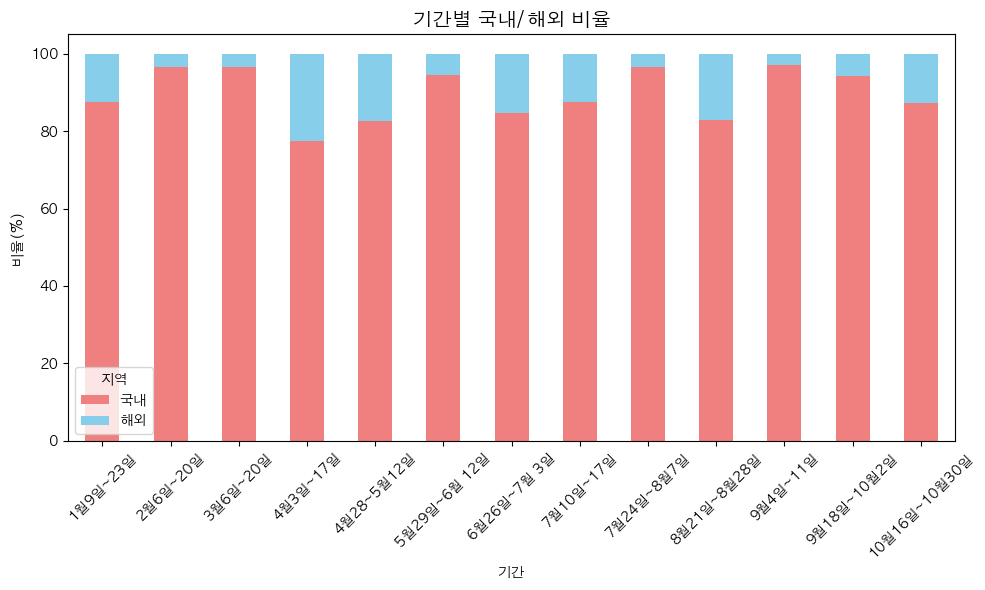

In [5]:
col_period = [c for c in region_df.columns if "기간" in c][0]
col_region = [c for c in region_df.columns if "지역" in c][0]
col_rate = [c for c in region_df.columns if "비율" in c][0]

def extract_month(text):
    match = re.search(r"(\d+)월", str(text))
    return int(match.group(1)) if match else 0

region_df["월"] = region_df[col_period].apply(extract_month)
region_df.sort_values("월", inplace=True)

ordered_periods = region_df[col_period].unique()
region_df[col_period] = pd.Categorical(region_df[col_period], categories=ordered_periods, ordered=True)

pivot_region = region_df.pivot(
    index=col_period,
    columns=col_region,
    values=col_rate
).fillna(0)

pivot_region.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["lightcoral", "skyblue"]
)
plt.title("기간별 국내/해외 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 부정/긍정 비율

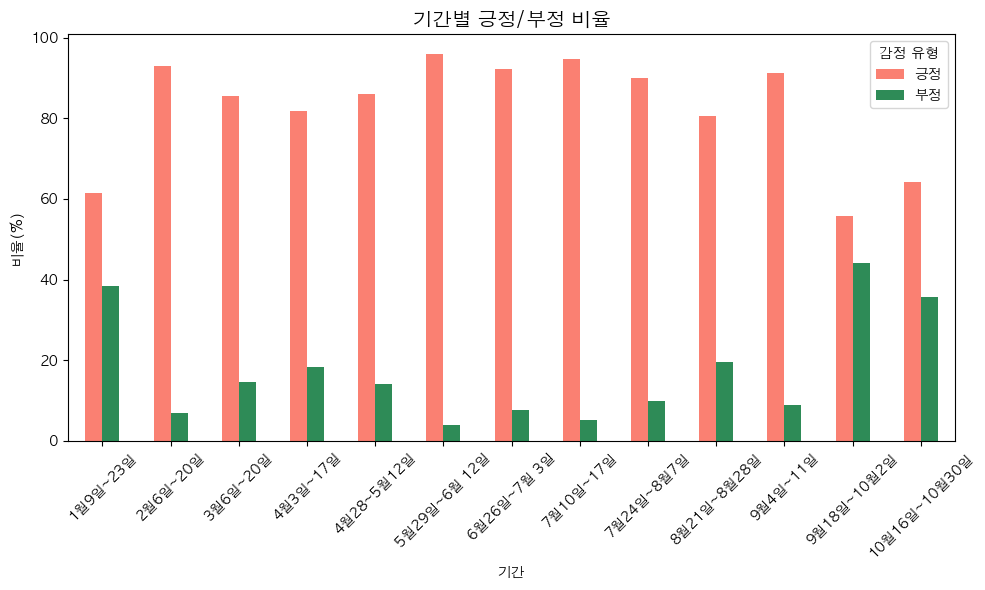

In [6]:
col_period = [c for c in neg_df.columns if "기간" in c or "period" in c][0]
col_sentiment = [c for c in neg_df.columns if "부정" in c or "sentiment" in c][0]
col_rate = [c for c in neg_df.columns if "비율" in c or "rate" in c][0]

neg_df["월"] = neg_df[col_period].apply(extract_month)
neg_df.sort_values("월", inplace=True)

ordered_periods = neg_df[col_period].unique()
neg_df[col_period] = pd.Categorical(neg_df[col_period], categories=ordered_periods, ordered=True)

pivot_neg = neg_df.pivot(
    index=col_period,
    columns=col_sentiment,
    values=col_rate
).fillna(0)

pivot_neg.plot(kind="bar", figsize=(10, 6), color=["salmon", "seagreen"])
plt.title("기간별 긍정/부정 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.legend(title="감정 유형")
plt.tight_layout()
plt.show()

## 출처별 게시글 비율

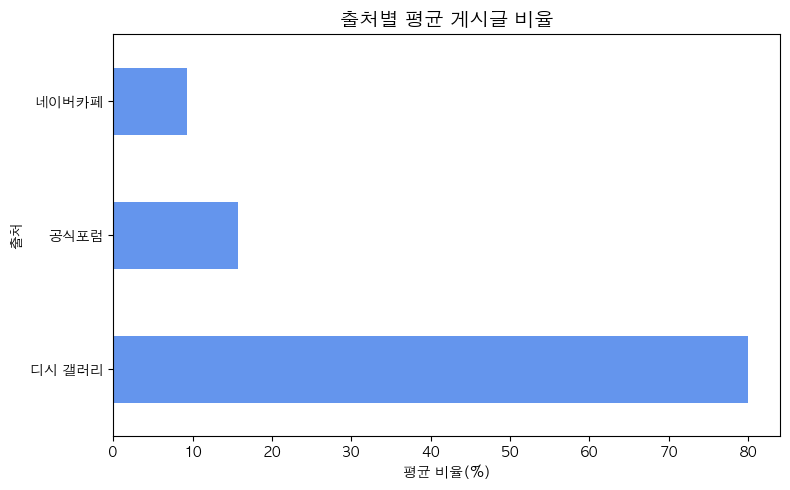

In [7]:
avg_source = source_df.groupby(col_source)[col_rate].mean().sort_values(ascending=False)
avg_source.plot(kind="barh", figsize=(8, 5), color="cornflowerblue")
plt.title("출처별 평균 게시글 비율", fontsize=14, weight="bold")
plt.xlabel("평균 비율(%)")
plt.ylabel("출처")
plt.tight_layout()
plt.show()

## 기간별 부정률 변화 추이

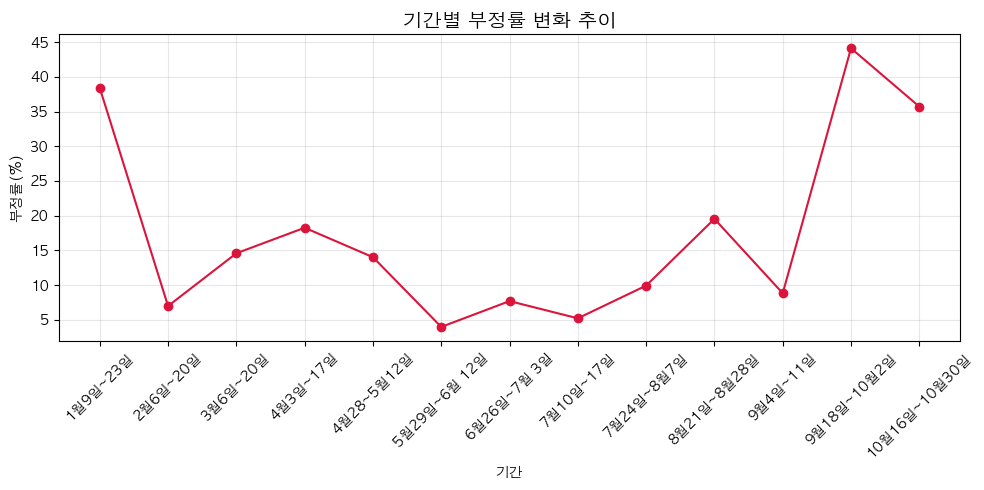

In [8]:
neg_trend = neg_df[neg_df[col_sentiment] == "부정"]

plt.figure(figsize=(10, 5))
plt.plot(neg_trend[col_period], neg_trend[col_rate], marker="o", color="crimson")
plt.title("기간별 부정률 변화 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("부정률(%)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 시장별 업데이트 긍정/부정 비율 추이

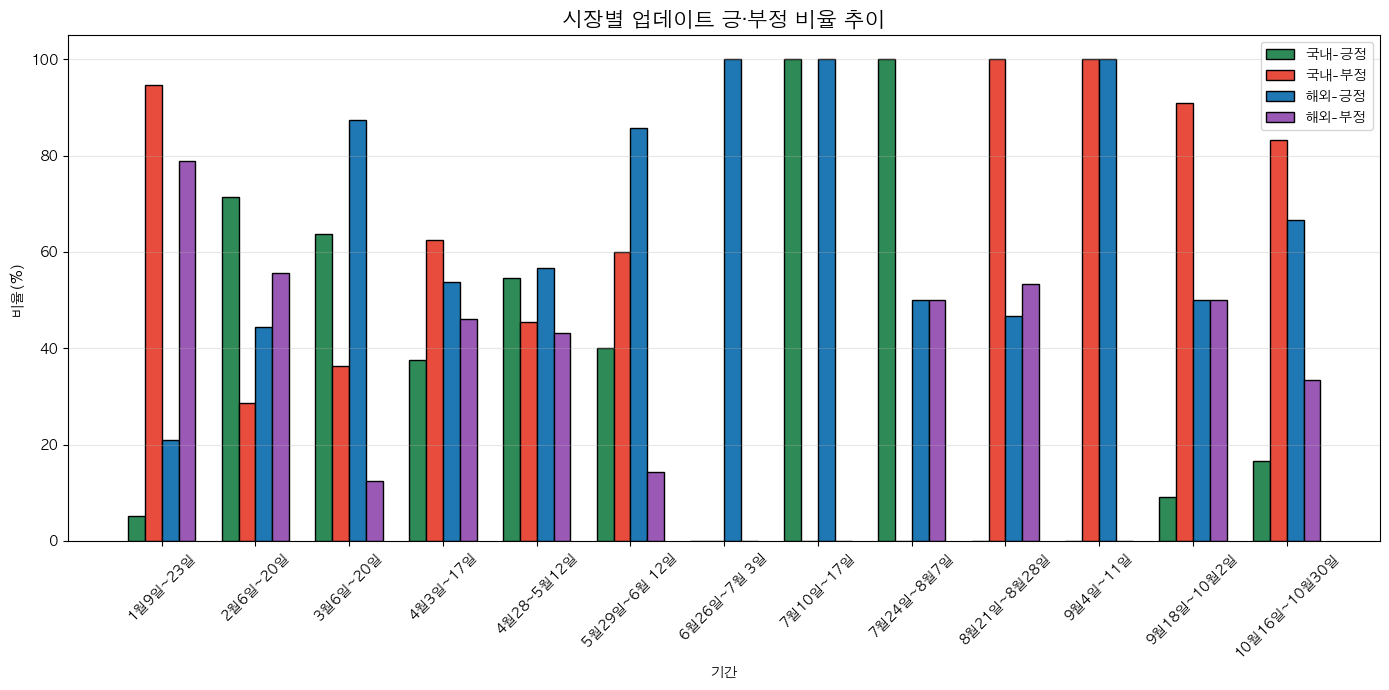

In [9]:
def extract_month_day(text):
    match = re.search(r"(\d+)월(\d+)일", str(text))
    if match:
        return int(match.group(1)), int(match.group(2))
    return (0, 0)

market_df["월"], market_df["일"] = zip(*market_df[col_period].apply(extract_month_day))
market_df.sort_values(["월", "일"], inplace=True)

pivot_update = market_df.pivot_table(
    index=col_period,
    columns=[col_region, col_sentiment],
    values=col_rate,
    aggfunc="mean"
).fillna(0)

ordered_periods = market_df[col_period].unique()
pivot_update = pivot_update.reindex(ordered_periods)

labels = pivot_update.index.tolist()
x = np.arange(len(labels))
bar_width = 0.18

colors = {
    ("국내", "긍정"): "#2E8B57",
    ("국내", "부정"): "#E74C3C",
    ("해외", "긍정"): "#1F77B4",
    ("해외", "부정"): "#9B59B6"
}

plt.figure(figsize=(14, 7))
for i, col in enumerate(pivot_update.columns):
    plt.bar(
        x + (i - 1.5) * bar_width,
        pivot_update[col],
        width=bar_width,
        color=colors.get(col, "gray"),
        edgecolor="black",
        label=f"{col[0]}-{col[1]}"
    )

plt.xticks(x, labels, rotation=45)
plt.title("시장별 업데이트 긍·부정 비율 추이", fontsize=15, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.grid(axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 지정일 부정 반응 유형 비율

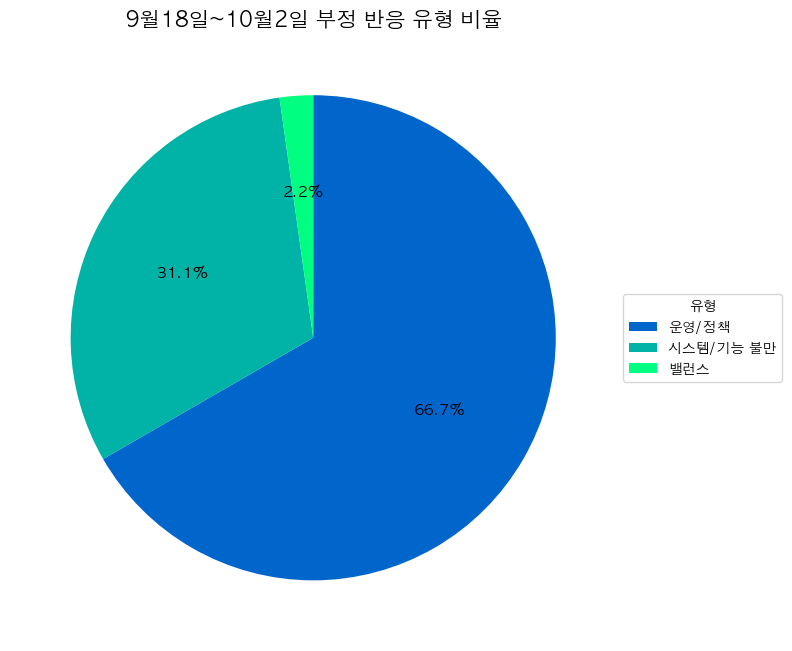

In [10]:
col_period = [c for c in neg_type_df.columns if "기간" in c][0]
col_type = [c for c in neg_type_df.columns if "유형" in c][0]
col_rate = [c for c in neg_type_df.columns if "비율" in c][0]

neg_type_df.sort_values(col_rate, ascending=False, inplace=True)
colors = plt.cm.winter(np.linspace(0.4, 1, len(neg_type_df)))

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    neg_type_df[col_rate],
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    counterclock=False,
    textprops={"fontsize": 11, "color": "black"}
)

plt.title("9월18일~10월2일 부정 반응 유형 비율", fontsize=15, weight="bold")
plt.legend(
    wedges,
    neg_type_df[col_type],
    title="유형",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.tight_layout()
plt.show()